In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234567',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Alina/Desktop/Projects/ecommace'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host = "localhost",
                          username ="root",
                          password = "1234567",
                          database = "ecommerce")
cur = db.cursor()

# List all unique cities where customers are located.

In [2]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017  """

cur.execute(query)

data = cur.fetchall()

"Total order placed in 2017 are", data[0][0]

('Total order placed in 2017 are', 45101)

# Find the total sales per category.

In [4]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["Category","sales"])
df

,Category,sales
0,PERFUMERY,2026954.64
1,FURNITURE DECORATION,5720705.57
2,TELEPHONY,1947528.20
3,BED TABLE BATH,6850214.68
4,AUTOMOTIVE,3409177.32
...,...,...
69,CDS MUSIC DVDS,4797.72
70,LA CUISINE,11654.12
71,FASHION CHILDREN'S CLOTHING,3142.68
72,PC GAMER,8697.72


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 
ELSE 0 END)/ COUNT(*))* 100 FROM payments;
"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]


('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

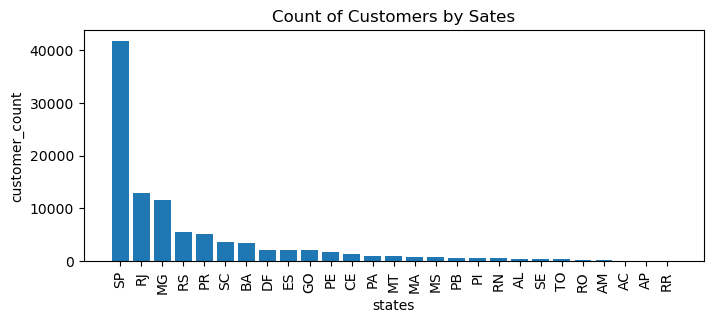

In [6]:
query = """ Select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["state","customer_count"])
df = df.sort_values(by ="customer_count", ascending= False)

plt.figure(figsize =(8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by Sates")
plt.show()

# Calculate the number of orders per month in 2018.

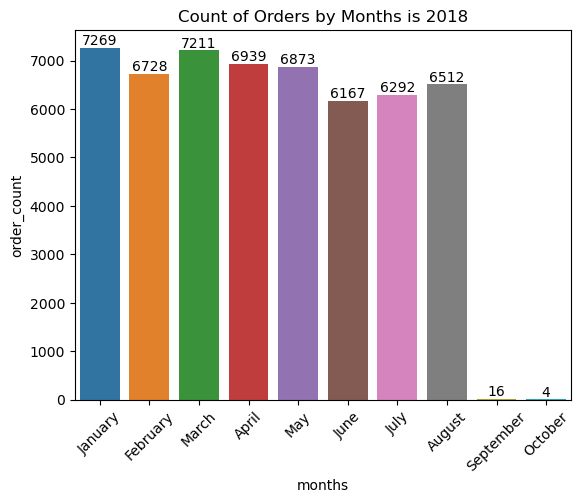

In [7]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)= 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x = df["months"],y = df["order_count"], data = df, order = month_order )
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [8]:
import mysql.connector

# Connect to your database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1234567",
    database="ecommerce"
)
cur = conn.cursor()

query = """
WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders JOIN order_items
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers JOIN count_per_order 
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by average_orders desc
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City", "Average Product/Orders"])
df.head(10)

,Customer City,Average Product/Orders
0,padre carvalho,14.00
1,celso ramos,13.00
2,candido godoi,12.00
3,datas,12.00
4,matias olimpio,10.00
5,morro de sao paulo,8.00
6,cidelandia,8.00
7,picarra,8.00
8,teixeira soares,8.00
9,curralinho,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [9]:
import mysql.connector

query = """
SELECT 
    UPPER(products.product_category) AS category, 
    ROUND(
        (SUM(payments.payment_value) / 
         (SELECT SUM(payment_value) FROM payments)) * 100, 2
    ) AS sales_percentage
FROM products 
JOIN order_items
    ON products.product_id = order_items.product_id
JOIN payments
    ON payments.order_id = order_items.order_id
GROUP BY category 
ORDER BY sales_percentage DESC
"""
cur.execute(query)


df = pd.DataFrame(data, columns=["Category", "percent distribution"])
df.head()

,Category,percent distribution
0,padre carvalho,14.00
1,celso ramos,13.00
2,candido godoi,12.00
3,datas,12.00
4,matias olimpio,10.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(host = "localhost",
                          username ="root",
                          password = "1234567",
                          database = "ecommerce")
cur = db.cursor()

# Connect to your database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1234567",
    database="ecommerce"
)
cur = conn.cursor()

query = """
select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The coorrelation between price and the number of time a product has been purchased is"),a[0][1]

The coorrelation between price and the number of time a product has been purchased is


(None, -0.10631514167157562)

# Calculate the total revenue generated by each seller, and rank them by revenue.

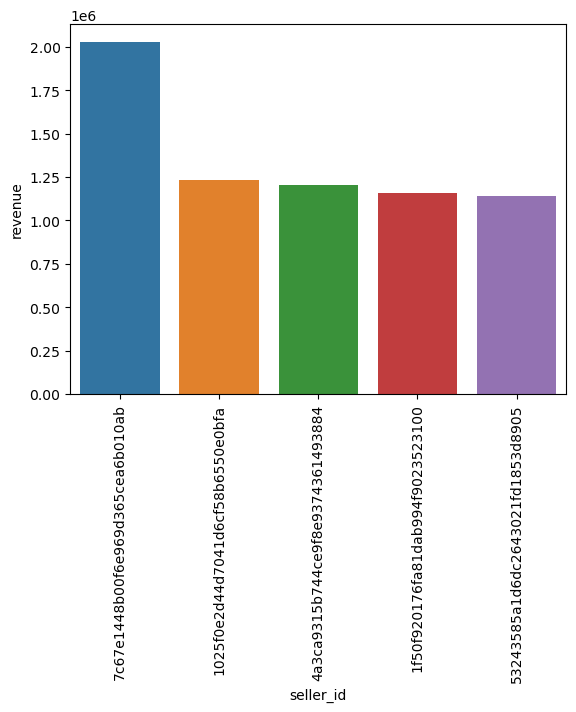

In [11]:

query = """ 
select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)revenue
from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y ="revenue", data = df)

plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [17]:

query = """
select customer_id, order_purchase_timestamp, payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id)as a;

"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [18]:
query = """
select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    ROUND(SUM(payments.payment_value), 2) AS Payment
FROM orders
JOIN payments ON orders.order_id = payments.order_id
GROUP BY years, months
ORDER BY years, months) as a
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df


,0,1,2,3
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# Calculate the year-over-year growth rate of total sales.

In [25]:
query = """
with a as (select 
    YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value), 2) AS Payment
FROM orders
JOIN payments ON orders.order_id = payments.order_id

GROUP BY years ORDER BY years)

select years, (payment - lag(payment, 1) over ( order by years))/ 
lag(payment, 1) over ( order by years) *100 from a
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =["Years", "Yoy % growth"])
df

,Years,Yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [26]:
query = """
WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT 
        a.customer_id, 
        COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
    FROM a
    JOIN orders ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6
        MONTH)
    GROUP BY a.customer_id
)
SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id))
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.


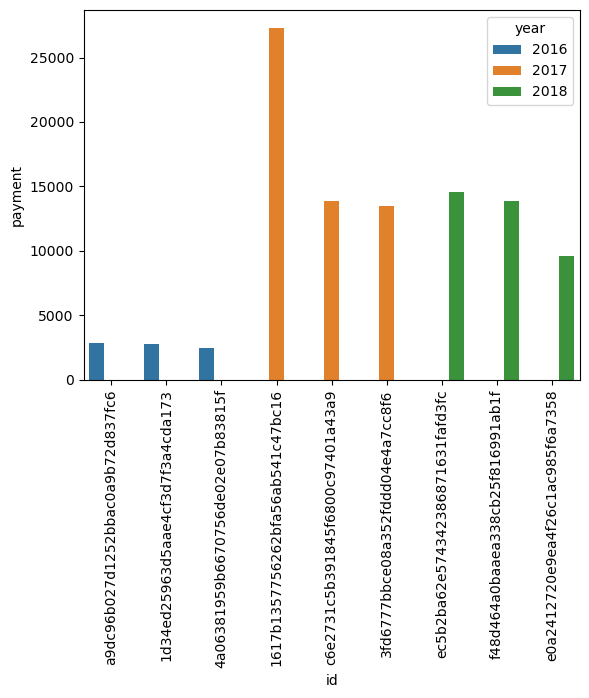

In [32]:
query = """
select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp)years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["year", "id","payment", "rank"])
sns.barplot(x ="id", y ="payment", data = df, hue = "year")
plt.xticks(rotation = 90)
plt.show()